In [2]:
import functools
from collections import namedtuple
from pathlib import Path

import numpy as np

from scipy import signal

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


# Data Loading

In [4]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [5]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

In [6]:
assert torch.all(torch.stack(wls)==wls[0])
wl = wls[0]
del wls

In [7]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

In [8]:
fluxes.shape, infeatures.shape

(torch.Size([7508, 2048]), torch.Size([7508, 3]))

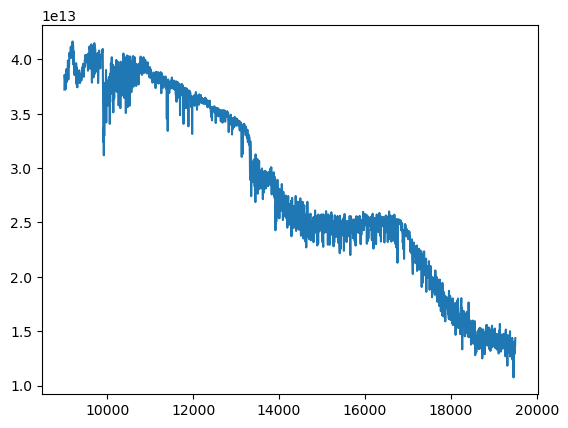

In [9]:
plt.plot(wl, fluxes[1000])

tensor(1901)

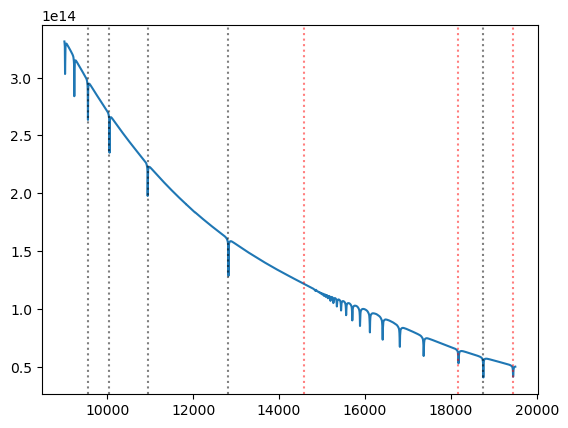

In [33]:
plt.plot(wl, fluxes[4000])
xs = plt.xlim()
for wll in [1875, 1282, 1094, 1005, 954.6, 820.4]: #bracket
    plt.axvline(wll*10,c='k', alpha=.5, ls=':')
for wll in [4051, 2625, 2166, 1944, 1817 , 1458]: # paschen
    plt.axvline(wll*10,c='r', alpha=.5, ls=':')
plt.xlim(*xs)
closest_idx_to_balpha = np.argsort((wl-18750)**2)[0]
closest_idx_to_balpha

/tmp/ipykernel_5125/775368354.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(*infeatures.T[:2], c=np.log10(pxvals), s=1, alpha=.5)


Text(0, 0.5, 'logg')

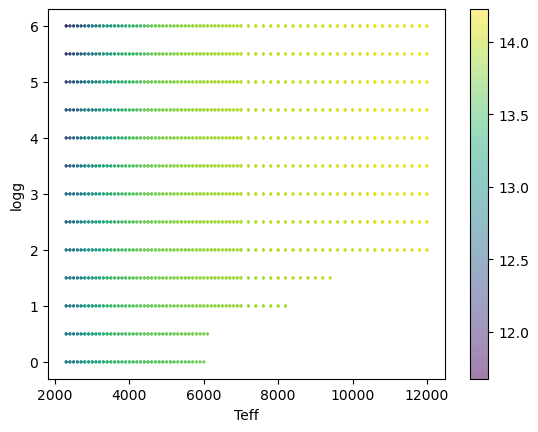

In [53]:
# a "regular" part of the spectrum
pxvals = fluxes[:, closest_idx_to_balpha-100]
plt.scatter(*infeatures.T[:2], c=np.log10(pxvals), s=1, alpha=.5)
plt.colorbar()
plt.xlabel(infeature_names[0])
plt.ylabel(infeature_names[1])

/tmp/ipykernel_5125/2760638504.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(*infeatures.T[:2], c=np.log10(pxvals), s=1, alpha=.5)


Text(0, 0.5, 'logg')

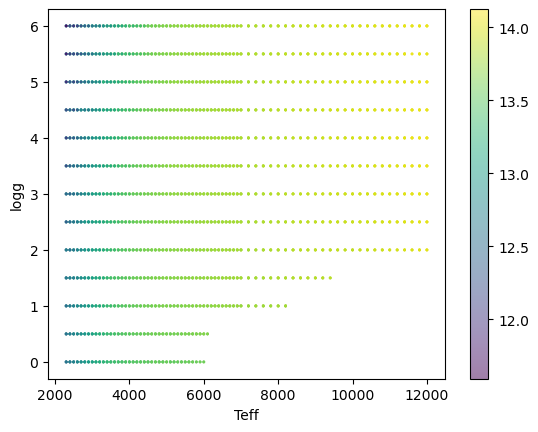

In [52]:
# balpha
pxvals = fluxes[:, closest_idx_to_balpha]
plt.scatter(*infeatures.T[:2], c=np.log10(pxvals), s=1, alpha=.5)
plt.colorbar()
plt.xlabel(infeature_names[0])
plt.ylabel(infeature_names[1])

Text(0, 0.5, 'FeH')

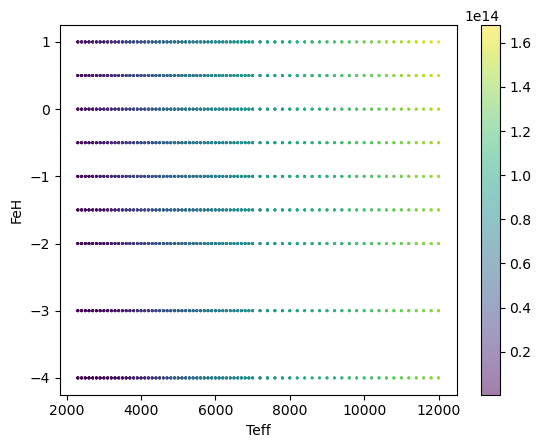

In [67]:
# a "regular" part of the spectrum
pxvals = fluxes[:, closest_idx_to_balpha-100]
plt.scatter(infeatures.T[0], infeatures.T[2], c=pxvals, s=1, alpha=.5)
plt.colorbar()
plt.xlabel(infeature_names[0])
plt.ylabel(infeature_names[2])

Oddly not at all informative... Try slices?

Text(0.5, 0, 'Teff')

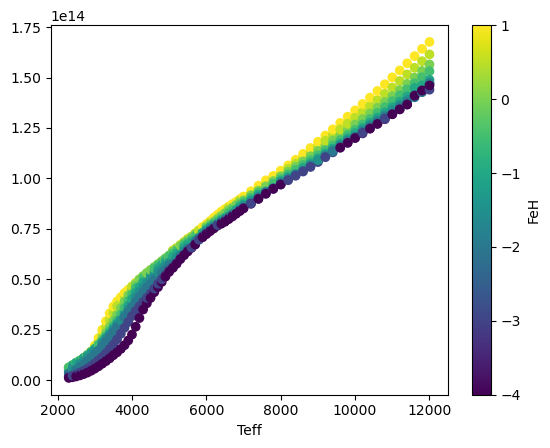

In [77]:
# a "regular" part of the spectrum
pxvals = fluxes[:, closest_idx_to_balpha-100]

msk = infeatures[:,1]==4
plt.scatter(infeatures[msk, 0], pxvals[msk], c=infeatures[msk, 2])
plt.colorbar().set_label(infeature_names[2])
plt.xlabel(infeature_names[0])

Text(0.5, 0, 'Teff')

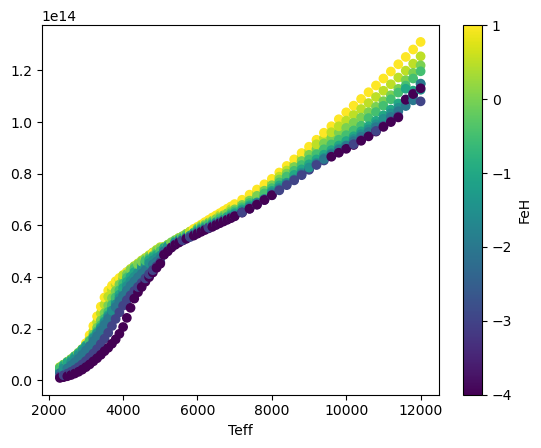

In [78]:
# balpha
pxvals = fluxes[:, closest_idx_to_balpha]

msk = infeatures[:,1]==4
plt.scatter(infeatures[msk, 0], pxvals[msk], c=infeatures[msk, 2])
plt.colorbar().set_label(infeature_names[2])
plt.xlabel(infeature_names[0])

Text(0.5, 0, 'Teff')

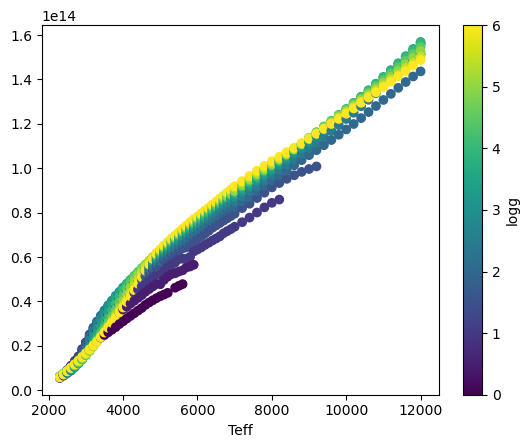

In [79]:
# a "regular" part of the spectrum
pxvals = fluxes[:, closest_idx_to_balpha-100]

msk = infeatures[:,2]==0
plt.scatter(infeatures[msk, 0], pxvals[msk], c=infeatures[msk, 1])
plt.colorbar().set_label(infeature_names[1])
plt.xlabel(infeature_names[0])

Text(0.5, 0, 'Teff')

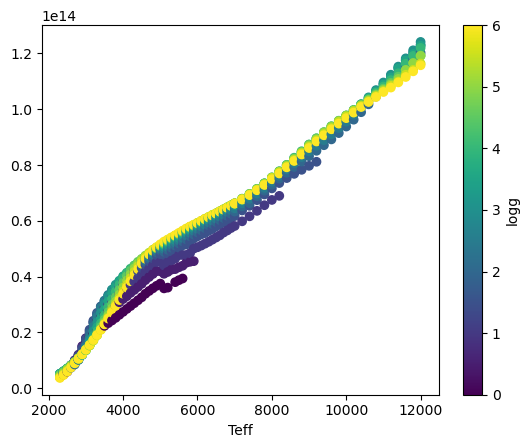

In [80]:
# balpha
pxvals = fluxes[:, closest_idx_to_balpha]


msk = infeatures[:,2]==0
plt.scatter(infeatures[msk, 0], pxvals[msk], c=infeatures[msk, 1])
plt.colorbar().set_label(infeature_names[1])
plt.xlabel(infeature_names[0])

/tmp/ipykernel_5125/2623519641.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sc = ax.scatter(*infeatures.T, c=np.log10(pxvals), s=1, alpha=.8)


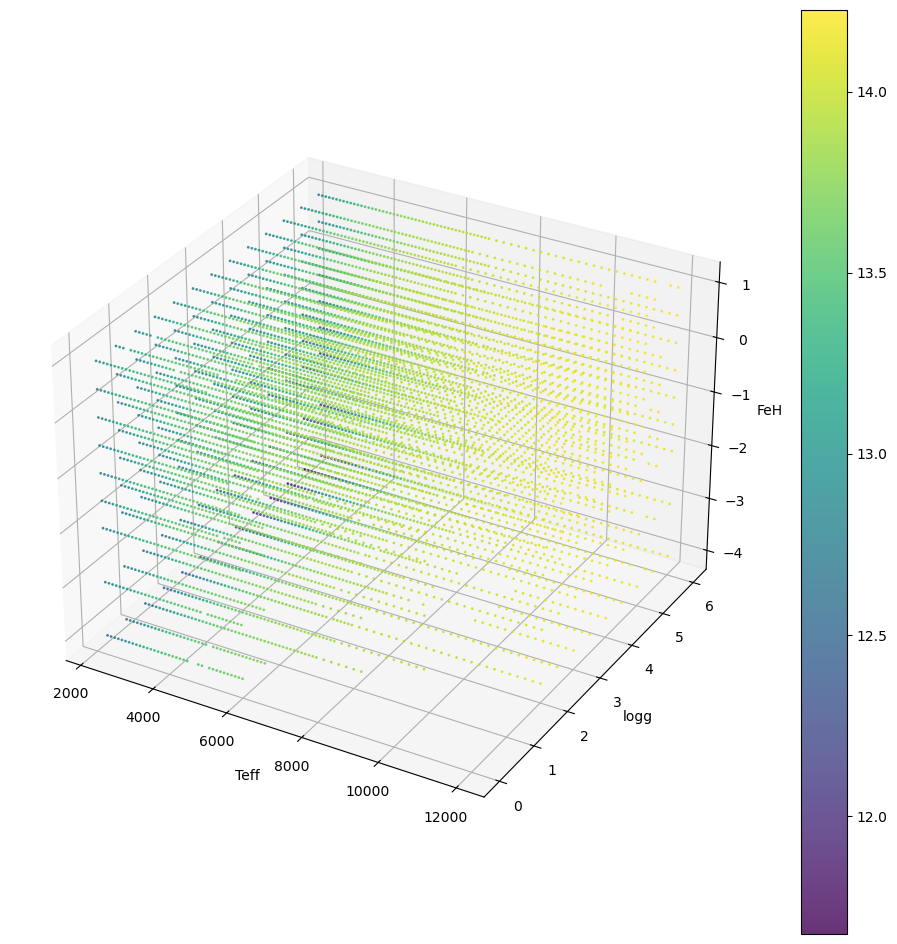

In [92]:
# a "regular" part of the spectrum
pxvals = fluxes[:, closest_idx_to_balpha-100]


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(*infeatures.T, c=np.log10(pxvals), s=1, alpha=.8)
plt.colorbar(sc)

ax.set_xlabel(infeature_names[0])
ax.set_ylabel(infeature_names[1])
ax.set_zlabel(infeature_names[2]);

/tmp/ipykernel_5125/1376266836.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sc = ax.scatter(*infeatures.T, c=np.log10(pxvals), s=1, alpha=.8)


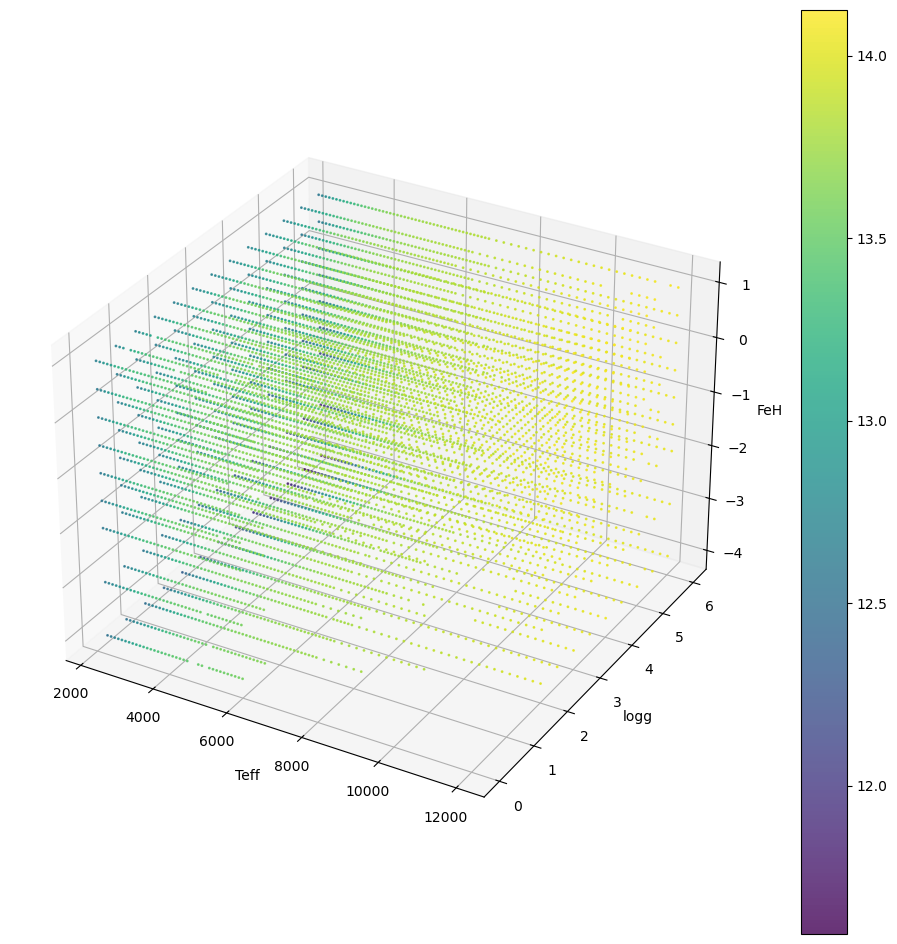

In [93]:
# balpha
pxvals = fluxes[:, closest_idx_to_balpha]


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(*infeatures.T, c=np.log10(pxvals), s=1, alpha=.8)
plt.colorbar(sc)

ax.set_xlabel(infeature_names[0])
ax.set_ylabel(infeature_names[1])
ax.set_zlabel(infeature_names[2]);

Not really much to lear from this... what about frequency space?

# Fourier-based representations

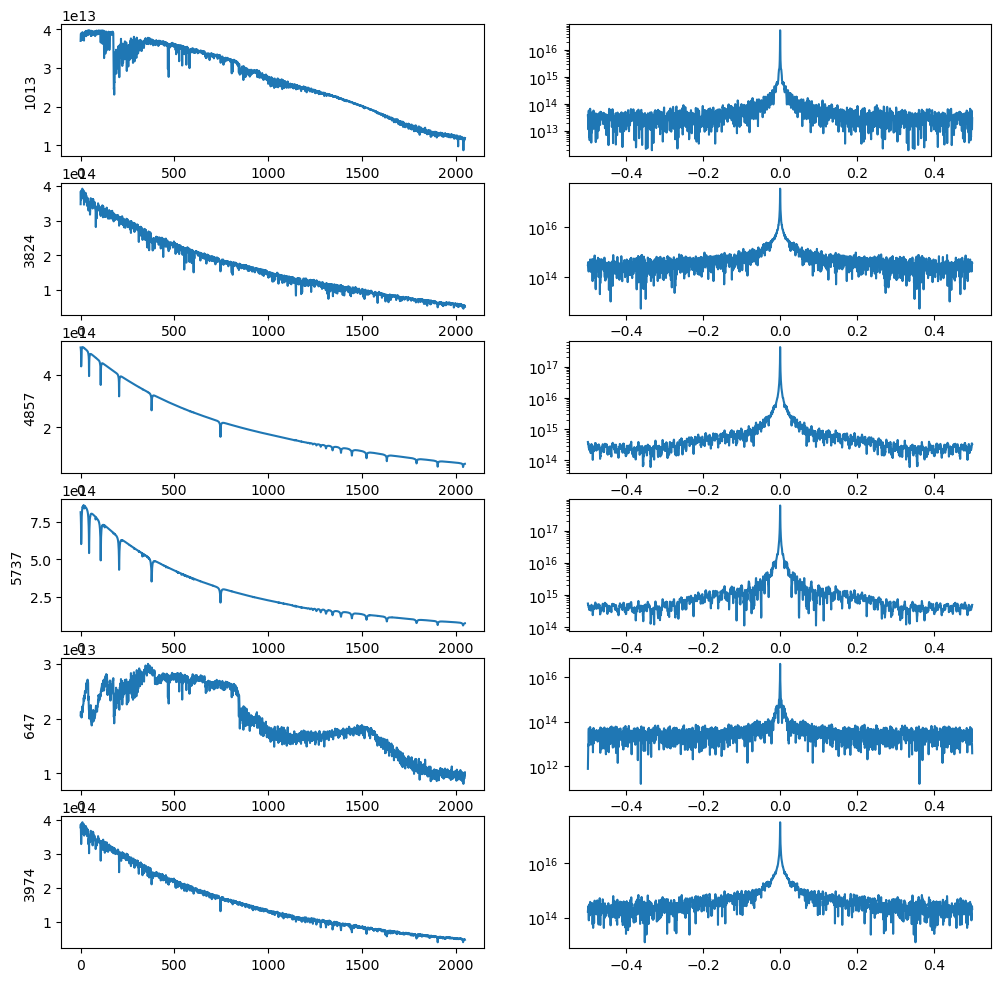

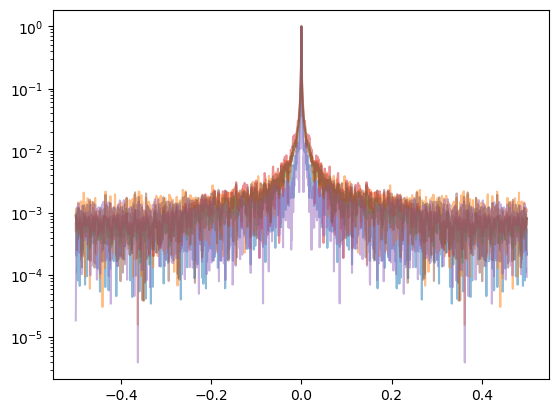

In [294]:
randidxs = np.random.permutation(fluxes.shape[0])[:6]

fftluxes = torch.fft.fft(fluxes, dim=-1)

f = torch.fft.fftshift(torch.fft.fftfreq(fftluxes.shape[1]))

ffts = []
fig, axs = plt.subplots(6,2, figsize=(12, 12))
for axrow, flux, fftlux, idx in zip(axs, fluxes[randidxs], fftluxes[randidxs], randidxs):
    ax1, ax2 = axrow
    ax1.plot(flux)
    ffts.append(torch.fft.fftshift(fftlux.abs()))
    ax2.plot(f, ffts[-1])
    ax2.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

May be mopre useful.  TBD in [fourier_exploration.ipynb](fourier_exploration.ipynb)